In [1]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "/content/gdrive/My Drive/A_05_Part_02_Dataset.zip"

Mounted at ./gdrive
Archive:  /content/gdrive/My Drive/A_05_Part_02_Dataset.zip
replace A_05_Part_02_Dataset/Test/0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
from numpy import savetxt
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sklearn
from sklearn.metrics import multilabel_confusion_matrix

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super(FocalLoss,self).__init__()
        self.gamma = gamma

    def forward(self, inputs, targets):
        loss = nn.BCEWithLogitsLoss(reduction="none")
        BCE_loss = loss(inputs,targets)
        pt = torch.exp(-BCE_loss)
        F_loss = (1-pt)**self.gamma * BCE_loss
        return torch.sum(F_loss)/inputs.shape[0]

In [0]:
#Following function taken from the fellow student's repository: https://github.com/Muhammad-Junaid-Ahmad/BSCS17012_COVID19_DLSpring2020
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    
    title = 'Confusion Matrix'

    # Compute confusion matrix
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    
    print('Confusion Matrix')
    
    Aclasses = [[classes[1]+ "+" +classes[2], classes[0]],
                [classes[0]+ "+" +classes[2], classes[1]],
                [classes[0]+ "+" +classes[1],classes[2]]]
    
    for cm,classes in zip(mcm, Aclasses):
        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=classes, yticklabels=classes,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        
    return

In [0]:
data_dir = './A_05_Part_02_Dataset'

In [41]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/Test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/Validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


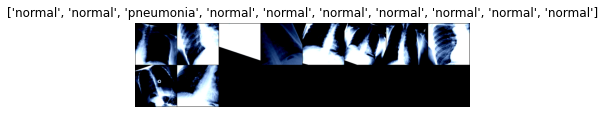

In [42]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [0]:
task=2

In [26]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
num_features = vgg16.classifier[0].in_features
features = list(vgg16.classifier.children())[:-7] # Remove all FC layers
features.extend([nn.Linear(num_features, 768, bias=True)])
features.extend([nn.ReLU(inplace=True)])
features.extend([nn.Dropout(p=0.5, inplace=False)])
features.extend([nn.Linear(768, len(class_names), bias=True)])

In [28]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [0]:
if task==1:
  criterion = nn.BCEWithLogitsLoss()
elif task==2:
  criterion = FocalLoss()

In [31]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
loss_values = []
acc_values = []

In [0]:
if task==2:
  vgg16.load_state_dict(torch.load('vgg16_focal_loss.pth'))

In [17]:
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = torch.sparse.torch.eye(3).index_select(dim=0, index=labels)
        for l in labels:
          if l[0]==1:
            l[2]=1
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    loss_values.append(running_loss / len(trainloader))
    print('Loss:', running_loss / len(trainloader))

    correct = 0
    total = 0
    val_set = []
    val_preds = []
    with torch.no_grad():
        for data in valloader:
            images, lbls = data
            lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
            for l in lbls:
              if l[0]==1:
                l[2]=1
            images, lbls = images.to(device), lbls.to(device)
            outs = vgg16(images)
            sig = nn.Sigmoid()
            predicted = sig(outs)
            predicted[predicted > 0.5] = 1
            predicted[predicted <= 0.5] = 0
            total += lbls.size(0)
            correct += ((predicted == lbls).all(axis=1)).sum().item()
            val_set.append(lbls)
            val_preds.append(predicted)
            
    val_set = torch.cat(val_set)
    val_preds = torch.cat(val_preds)
    acc = 100 * correct / total
    print('Accuracy: %f %%' % (acc))

    acc_values.append(acc)

    if task==2:
      torch.save(vgg16.state_dict(), 'vgg16_focal_loss.pth')

print('Finished Training')

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.188537: : 620it [03:06,  3.32it/s]


Loss: 0.279480019920776


0it [00:00, ?it/s]

Accuracy: 84.394904 %


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.258287: : 620it [03:01,  3.41it/s]


Loss: 0.2137357401451276


0it [00:00, ?it/s]

Accuracy: 87.898089 %


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.167498: : 620it [03:00,  3.44it/s]


Loss: 0.18653965969419767


0it [00:00, ?it/s]

Accuracy: 88.853503 %


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.112377: : 620it [02:59,  3.45it/s]


Loss: 0.17146881694394733
Accuracy: 88.694268 %


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.229015: : 620it [02:59,  3.45it/s]


Loss: 0.16616533297684885
Accuracy: 90.127389 %


Train Epoch: 5 [6190/6200 (100%)]	Loss: 0.262216: : 620it [03:01,  3.42it/s]


Loss: 0.16210713902969034


0it [00:00, ?it/s]

Accuracy: 89.649682 %


Train Epoch: 6 [6190/6200 (100%)]	Loss: 0.250969: : 620it [03:00,  3.44it/s]


Loss: 0.1520803657450503


0it [00:00, ?it/s]

Accuracy: 89.331210 %


Train Epoch: 7 [6190/6200 (100%)]	Loss: 0.220918: : 620it [03:00,  3.43it/s]


Loss: 0.15087963275220845


0it [00:00, ?it/s]

Accuracy: 89.968153 %


Train Epoch: 8 [6190/6200 (100%)]	Loss: 0.127747: : 620it [03:01,  3.42it/s]


Loss: 0.15290703627190763


0it [00:00, ?it/s]

Accuracy: 90.764331 %


Train Epoch: 9 [2520/6200 (41%)]	Loss: 0.031108: : 253it [01:12,  3.59it/s]

KeyboardInterrupt: ignored

In [0]:
correct = 0
total = 0
trains_set = []
train_preds = []
with torch.no_grad():
    for data in trainloader:
        images, lbls = data
        lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
        for l in lbls:
          if l[0]==1:
            l[2]=1
        images, lbls = images.to(device), lbls.to(device)
        outs = vgg16(images)
        sig = nn.Sigmoid()
        predicted = sig(outs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        total += lbls.size(0)
        correct += ((predicted == lbls).all(axis=1)).sum().item()
        trains_set.append(lbls)
        train_preds.append(predicted)
            
trains_set = torch.cat(trains_set)
train_preds = torch.cat(train_preds)

Confusion Matrix


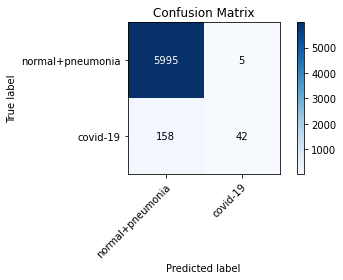

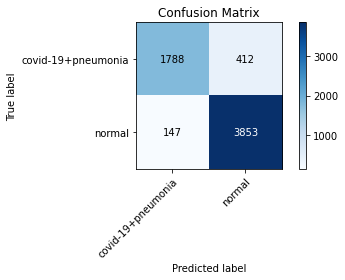

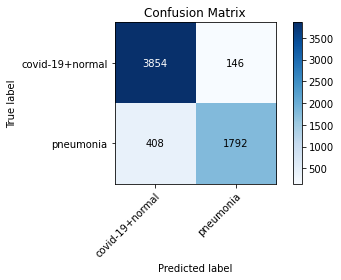

In [20]:
plot_confusion_matrix(trains_set.cpu().numpy(), train_preds.cpu().numpy(), class_names, title="Training Data Confusion Matrix")

In [0]:
correct = 0
total = 0
val_set = []
val_preds = []
with torch.no_grad():
    for data in valloader:
        images, lbls = data
        lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
        for l in lbls:
          if l[0]==1:
            l[2]=1
        images, lbls = images.to(device), lbls.to(device)
        outs = vgg16(images)
        sig = nn.Sigmoid()
        predicted = sig(outs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        total += lbls.size(0)
        correct += ((predicted == lbls).all(axis=1)).sum().item()
        val_set.append(lbls)
        val_preds.append(predicted)
            
val_set = torch.cat(val_set)
val_preds = torch.cat(val_preds)

Confusion Matrix


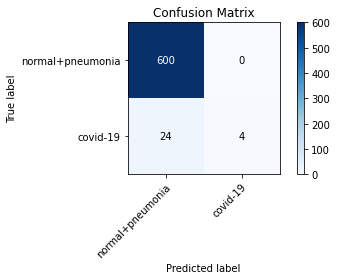

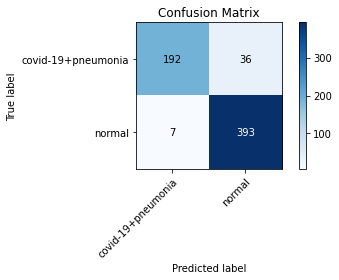

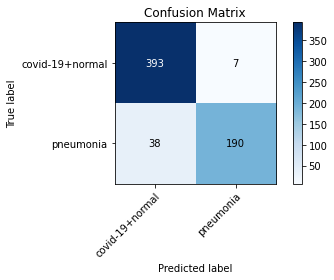

In [22]:
plot_confusion_matrix(val_set.cpu().numpy(), val_preds.cpu().numpy(), class_names, title="Validation Data Confusion Matrix")

In [120]:
f1score = sklearn.metrics.f1_score(val_set.cpu(), val_preds.cpu(), average=None)
print('F1 Score:', f1score)

F1 Score: [0.25       0.94813028 0.89411765]


Loss Curve


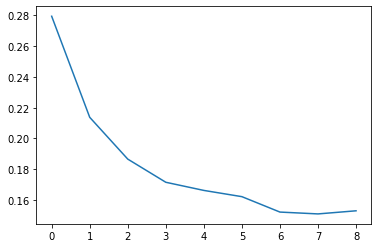

In [23]:
print('Loss Curve')
plt.plot(loss_values)

Accuracy Curve


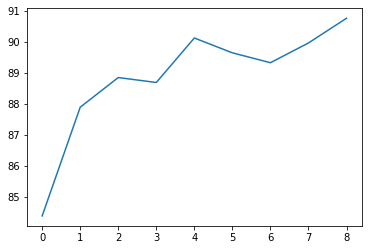

In [24]:
print('Accuracy Curve')
plt.plot(acc_values)

In [44]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [46]:
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(nn.Linear(num_features, 256), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(256, len(class_names)))
print(resnet18.fc)

Sequential(
  (0): Linear(in_features=512, out_features=256, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=256, out_features=3, bias=True)
)


In [47]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

In [0]:
if task==1:
  criterion = nn.BCEWithLogitsLoss()
elif task==2:
  criterion = FocalLoss()

In [50]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
loss_values = []
acc_values = []

In [0]:
if task==2:
  resnet18.load_state_dict(torch.load('res18_focal_loss.pth'))

In [15]:
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        labels = torch.sparse.torch.eye(3).index_select(dim=0, index=labels)
        for l in labels:
          if l[0]==1:
            l[2]=1
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    loss_values.append(running_loss / len(trainloader))
    print('Loss:', running_loss / len(trainloader))

    correct = 0
    total = 0
    val_set = []
    val_preds = []
    with torch.no_grad():
        for data in valloader:
            images, lbls = data
            lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
            for l in lbls:
              if l[0]==1:
                l[2]=1
            images, lbls = images.to(device), lbls.to(device)
            outs = resnet18(images)
            sig = nn.Sigmoid()
            predicted = sig(outs)
            predicted[predicted > 0.5] = 1
            predicted[predicted <= 0.5] = 0
            total += lbls.size(0)
            correct += ((predicted == lbls).all(axis=1)).sum().item()
            val_set.append(lbls)
            val_preds.append(predicted)
            
    val_set = torch.cat(val_set)
    val_preds = torch.cat(val_preds)
    acc = 100 * correct / total
    print('Accuracy: %f %%' % (acc))

    acc_values.append(acc)

    if task==2:
      torch.save(resnet18.state_dict(), 'res18_focal_loss.pth')

print('Finished Training')

Train Epoch: 0 [6190/6200 (100%)]	Loss: 0.238529: : 620it [02:22,  4.35it/s]


Loss: 0.3616559557376369


0it [00:00, ?it/s]

Accuracy: 64.649682 %


Train Epoch: 1 [6190/6200 (100%)]	Loss: 0.288708: : 620it [02:23,  4.33it/s]


Loss: 0.2930801015106901


0it [00:00, ?it/s]

Accuracy: 78.025478 %


Train Epoch: 2 [6190/6200 (100%)]	Loss: 0.467416: : 620it [02:23,  4.31it/s]


Loss: 0.25911560081426177


0it [00:00, ?it/s]

Accuracy: 79.777070 %


Train Epoch: 3 [6190/6200 (100%)]	Loss: 0.272436: : 620it [02:23,  4.31it/s]


Loss: 0.24593669761332773


0it [00:00, ?it/s]

Accuracy: 81.528662 %


Train Epoch: 4 [6190/6200 (100%)]	Loss: 0.173202: : 620it [02:21,  4.37it/s]


Loss: 0.2254430322276969


0it [00:00, ?it/s]

Accuracy: 83.121019 %


Train Epoch: 5 [6190/6200 (100%)]	Loss: 0.086858: : 620it [02:21,  4.38it/s]


Loss: 0.2154454624761016


0it [00:00, ?it/s]

Accuracy: 84.394904 %


Train Epoch: 6 [6190/6200 (100%)]	Loss: 0.302099: : 620it [02:21,  4.40it/s]


Loss: 0.21390783809005254


0it [00:00, ?it/s]

Accuracy: 83.439490 %


Train Epoch: 7 [6190/6200 (100%)]	Loss: 0.202096: : 620it [02:19,  4.45it/s]


Loss: 0.20653585938196029


0it [00:00, ?it/s]

Accuracy: 84.394904 %


Train Epoch: 8 [6190/6200 (100%)]	Loss: 0.635528: : 620it [02:19,  4.43it/s]


Loss: 0.19773280184956327


0it [00:00, ?it/s]

Accuracy: 85.509554 %


Train Epoch: 9 [6190/6200 (100%)]	Loss: 0.128313: : 620it [02:20,  4.41it/s]


Loss: 0.19992978573446313
Accuracy: 85.987261 %
Finished Training


In [0]:
correct = 0
total = 0
trains_set = []
train_preds = []
with torch.no_grad():
    for data in trainloader:
        images, lbls = data
        lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
        for l in lbls:
          if l[0]==1:
            l[2]=1
        images, lbls = images.to(device), lbls.to(device)
        outs = resnet18(images)
        sig = nn.Sigmoid()
        predicted = sig(outs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        total += lbls.size(0)
        correct += ((predicted == lbls).all(axis=1)).sum().item()
        trains_set.append(lbls)
        train_preds.append(predicted)
            
trains_set = torch.cat(trains_set)
train_preds = torch.cat(train_preds)

Confusion Matrix


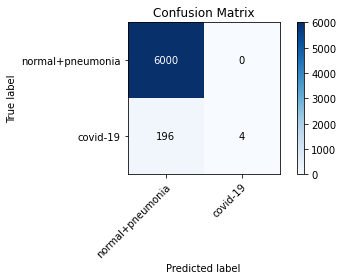

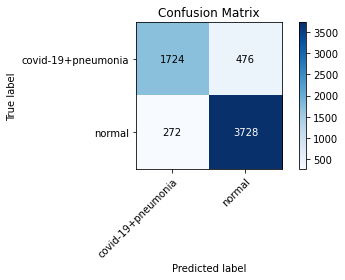

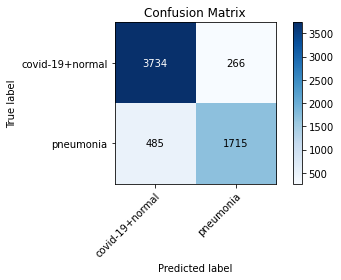

In [54]:
plot_confusion_matrix(trains_set.cpu().numpy(), train_preds.cpu().numpy(), class_names, title="Training Data Confusion Matrix")

In [0]:
correct = 0
total = 0
val_set = []
val_preds = []
with torch.no_grad():
    for data in valloader:
        images, lbls = data
        lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
        for l in lbls:
          if l[0]==1:
            l[2]=1
        images, lbls = images.to(device), lbls.to(device)
        outs = resnet18(images)
        sig = nn.Sigmoid()
        predicted = sig(outs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        total += lbls.size(0)
        correct += ((predicted == lbls).all(axis=1)).sum().item()
        val_set.append(lbls)
        val_preds.append(predicted)
            
val_set = torch.cat(val_set)
val_preds = torch.cat(val_preds)

Confusion Matrix


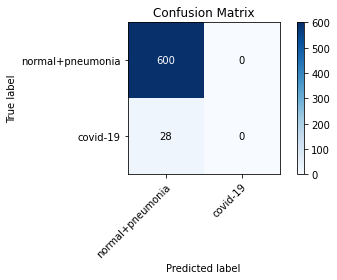

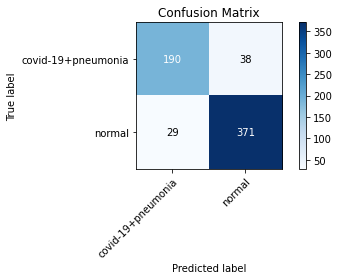

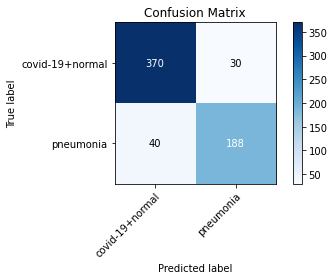

In [56]:
plot_confusion_matrix(val_set.cpu().numpy(), val_preds.cpu().numpy(), class_names, title="Validation Data Confusion Matrix")

In [57]:
f1score = sklearn.metrics.f1_score(val_set.cpu(), val_preds.cpu(), average=None)
print('F1 Score:', f1score)

F1 Score: [0.         0.91718171 0.84304933]


Loss Curve


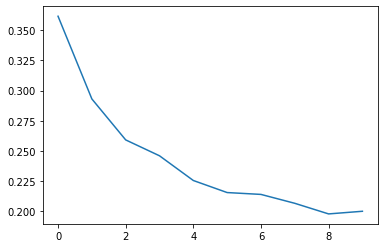

In [58]:
print('Loss Curve')
plt.plot(loss_values)

Accuracy Curve


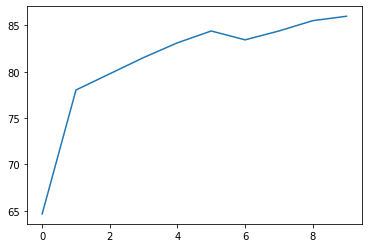

In [59]:
print('Accuracy Curve')
plt.plot(acc_values)

In [0]:
i = 0
test_preds = []
test_names = []
with torch.no_grad():
    for data in testloader:
        images, lbls = data
        lbls = torch.sparse.torch.eye(3).index_select(dim=0, index=lbls)
        for l in lbls:
          test_names.append(testloader.dataset.imgs[i][0][41:])
          i+=1
        images = images.to(device)
        outs = vgg16(images)
        sig = nn.Sigmoid()
        predicted = sig(outs)
        predicted[predicted > 0.5] = 1
        predicted[predicted <= 0.5] = 0
        test_preds.append(predicted)


test_preds = torch.cat(test_preds)

In [35]:
test_preds = test_preds.cpu().numpy()
test_preds[:,[1, 2]] = test_preds[:,[2, 1]]
test_preds = test_preds.astype(int)
test_names = np.array(test_names)
test_names = test_names[np.newaxis].T
output = np.append(test_names, test_preds, axis=1)
print(output)

[['0.png' '0' '0' '1']
 ['1.png' '0' '0' '1']
 ['10.png' '0' '1' '0']
 ...
 ['97.png' '0' '0' '1']
 ['98.png' '0' '0' '1']
 ['99.png' '0' '0' '1']]


In [0]:
fmt='%s, %s, %s, %s'
savetxt('BSCS17005_results.csv', output, delimiter=',', fmt=fmt)